# New York City - Taxi and Limousine Commission
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [2]:
# %load nbheader.py
%reload_ext autoreload
%autoreload 2
from typing import List, Tuple, Dict, Any, Union
import sys
import os
import re
import json
import datetime
import numpy as np
import pandas as pd
settings = {
    'max_columns': 50,
    'max_colwidth': 100,
    # 'min_rows':40,
    'max_rows': 200,
    # 'precision': 3,
    'float_format': lambda x: f'{x:,.2f}',
    }
for option, value in settings.items():
    pd.set_option("display.{}".format(option), value)
import matplotlib.pyplot as plt



# Load Data
Just one data file to explore

In [1]:
ls -lRh /data/nyc_tlc_trip_records/2023/

/data/nyc_tlc_trip_records/2023/:
total 3.7G
-rw-rw-r--. 1 pmolnar pmolnar  11M Mar 20  2023 fhv_tripdata_2023-01.parquet
-rw-rw-r--. 1 pmolnar pmolnar  13M May  1  2023 fhv_tripdata_2023-02.parquet
-rw-rw-r--. 1 pmolnar pmolnar  15M May 19  2023 fhv_tripdata_2023-03.parquet
-rw-rw-r--. 1 pmolnar pmolnar  14M Jun 23  2023 fhv_tripdata_2023-04.parquet
-rw-rw-r--. 1 pmolnar pmolnar  15M Jul 26  2023 fhv_tripdata_2023-05.parquet
-rw-rw-r--. 1 pmolnar pmolnar  14M Aug 22 09:23 fhv_tripdata_2023-06.parquet
-rw-rw-r--. 1 pmolnar pmolnar  11M Sep 21 18:40 fhv_tripdata_2023-07.parquet
-rw-rw-r--. 1 pmolnar pmolnar 452M Mar 20  2023 fhvhv_tripdata_2023-01.parquet
-rw-rw-r--. 1 pmolnar pmolnar 438M May  1  2023 fhvhv_tripdata_2023-02.parquet
-rw-rw-r--. 1 pmolnar pmolnar 499M May 19  2023 fhvhv_tripdata_2023-03.parquet
-rw-rw-r--. 1 pmolnar pmolnar 470M Jun 23  2023 fhvhv_tripdata_2023-04.parquet
-rw-rw-r--. 1 pmolnar pmolnar 490M Jul 26  2023 fhvhv_tripdata_2023-05.parquet
-rw-rw-r--. 1 pmolnar

In [2]:
df = pd.read_parquet('/data/nyc_tlc_trip_records/2023/yellow_tripdata_2023-07.parquet')
print(f"Number of records: {df.shape[0]:,}")

Number of records: 2,907,108


In [ ]:
display(df.dtypes)

In [ ]:
df.head()

In [ ]:
df.shape[1]

In [ ]:
df.describe().shape[1]

In [ ]:
ls -lR /data/nyc_tlc_trip_records/

# Data Quality Table

In [ ]:
data_quauality_1 = df.describe(include=['int64', 'float64']).T
display(data_quauality_1)

In [ ]:
data_quauality_2 = df.describe(exclude=['int64', 'float64', 'datetime']).T
display(data_quauality_2)

In [ ]:
df.shape

# Missing Values and Unique Values

In [ ]:
from data_exploration_helper import (
    nulls_uniques_count,
)

In [ ]:
nuc = nulls_uniques_count(df)
display(nuc)

combine information

In [ ]:
combined_data_quality = pd.DataFrame(df.dtypes, columns=['field_name']).join(nuc).join(data_quauality_1)
display(combined_data_quality)
print(f"Shape: {combined_data_quality.shape}")

In [ ]:
def data_quality_table(df: pd.DataFrame) -> pd.DataFrame:
    dt = pd.DataFrame(df.dtypes, columns=['field_name'])
    nuc = nulls_uniques_count(df)
    des = df.describe(include='all', datetime_is_numeric=True).T
    des = df.describe().T
    combined_data_quality = dt.join(nuc).join(des, how='left')
    return combined_data_quality

In [ ]:
data_quality_table(df)

# Outliers

<AxesSubplot:>

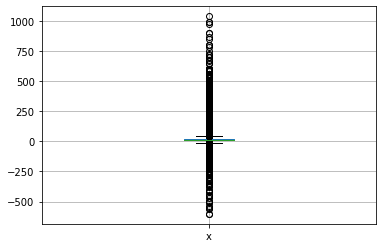

In [3]:
pd.plotting.boxplot(df.fare_amount)

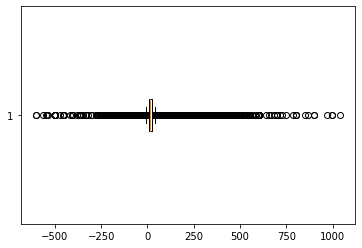

In [4]:
plt.boxplot(df.fare_amount, vert=False)
plt.show()

<AxesSubplot:>

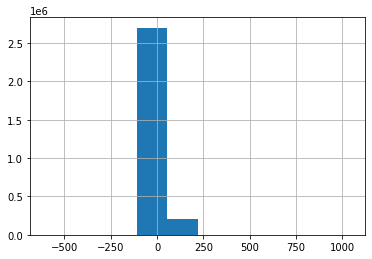

In [5]:
pd.plotting.hist_series(df.fare_amount)

In [10]:
(df.fare_amount<250).sum()

2906245

In [11]:
df1 = df[ (df.fare_amount<250) & ( df.fare_amount>0) ] 

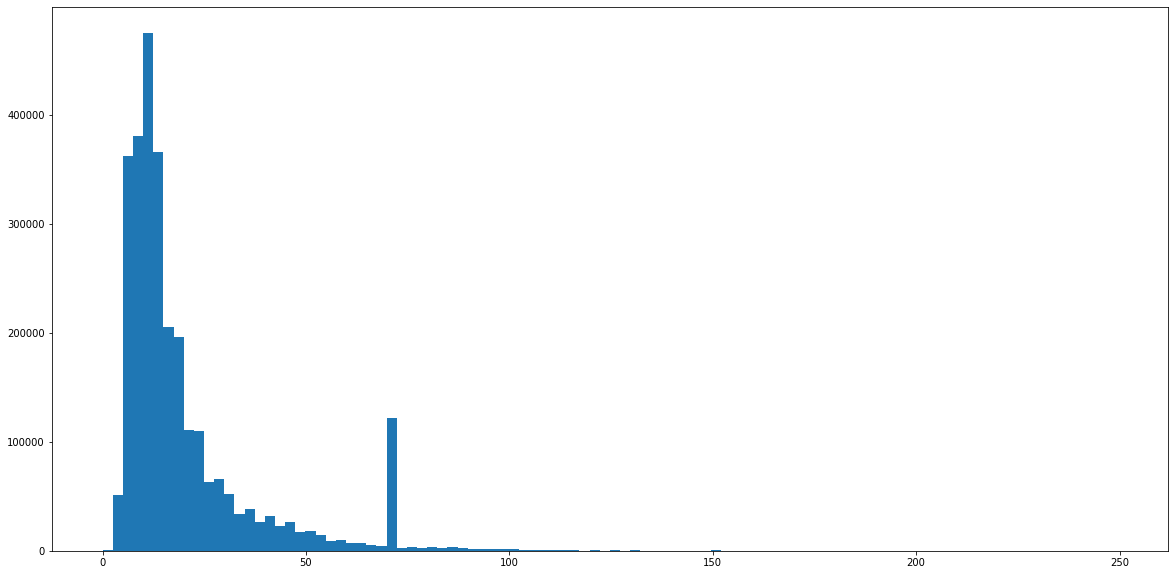

In [13]:
fig = plt.figure(figsize=(20,10))
plt.hist(df1.fare_amount, bins=100)
plt.show()

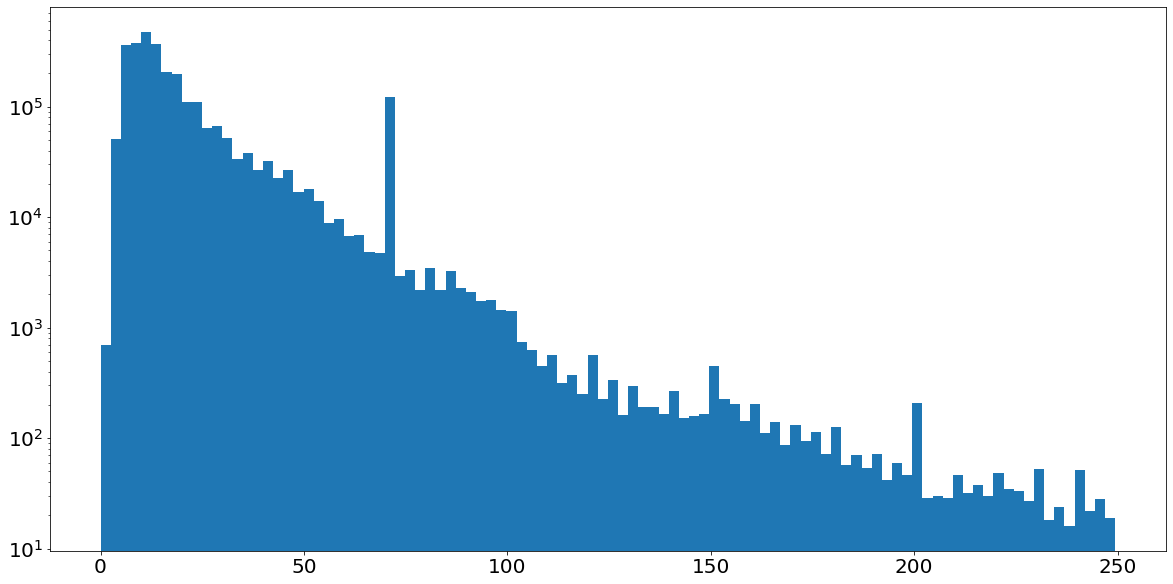

In [16]:
fig = plt.figure(figsize=(20,10))
plt.hist(df1.fare_amount, bins=100, log=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

numeric_columns = df.describe().columns

In [18]:
numeric_columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

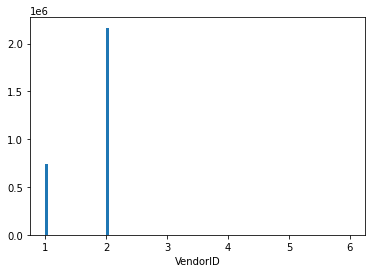

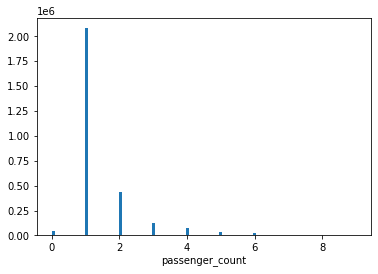

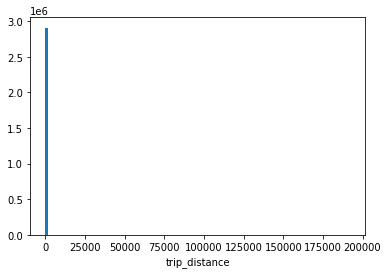

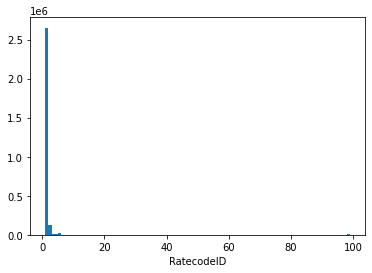

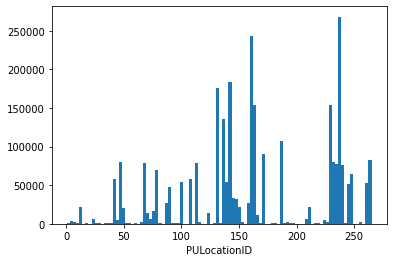

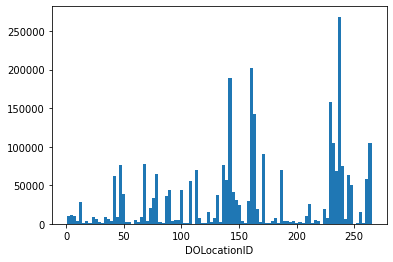

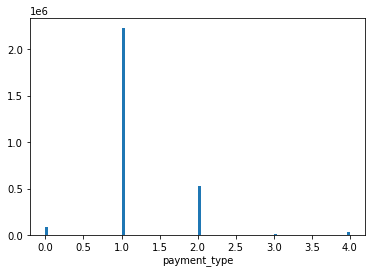

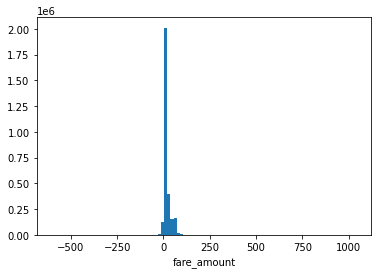

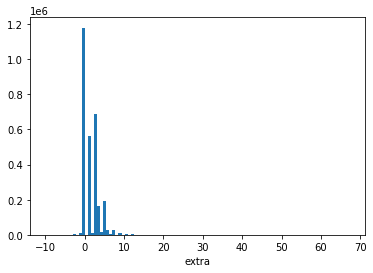

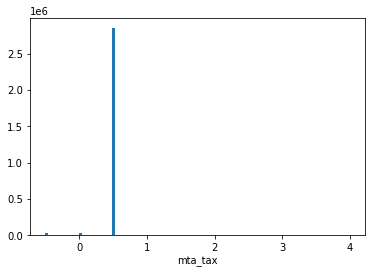

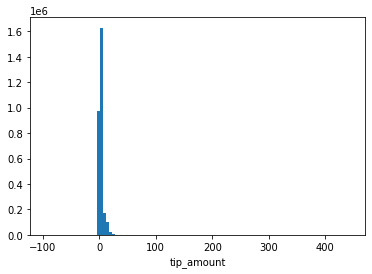

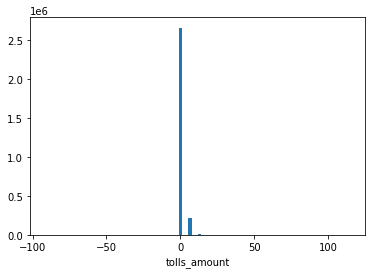

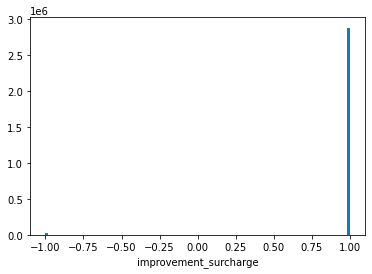

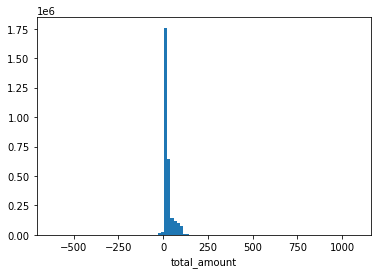

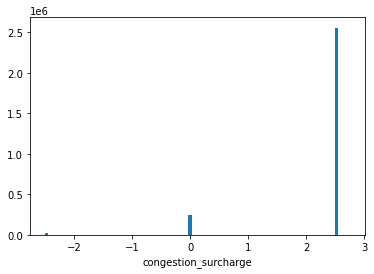

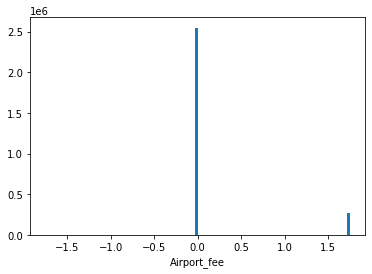

In [21]:
for col in numeric_columns:
    plt.hist(df[col], bins=100)
    plt.xlabel(col)
    plt.show()

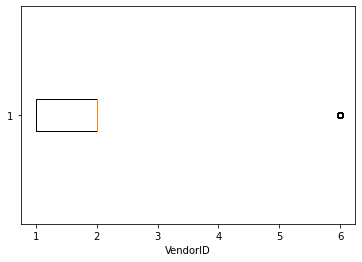

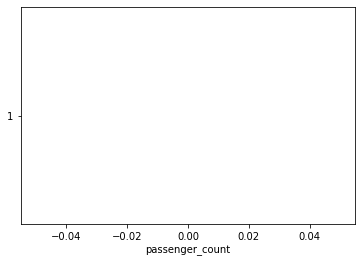

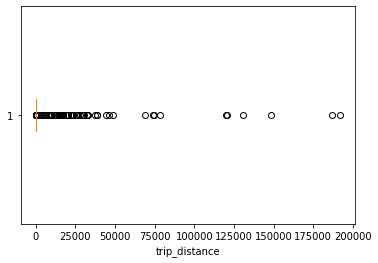

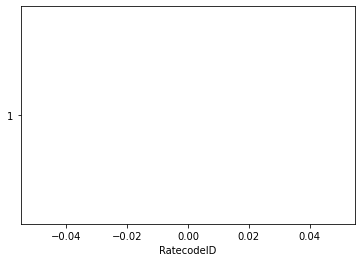

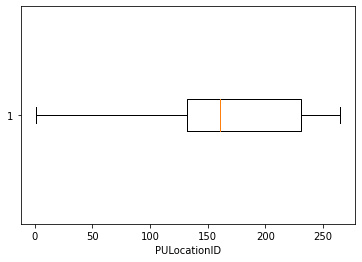

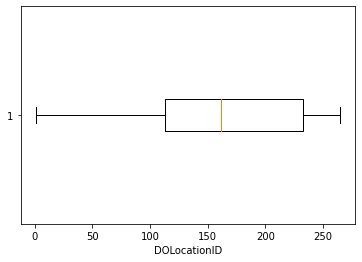

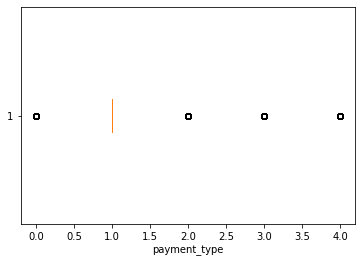

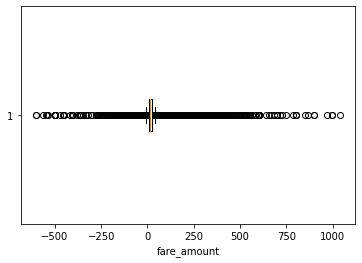

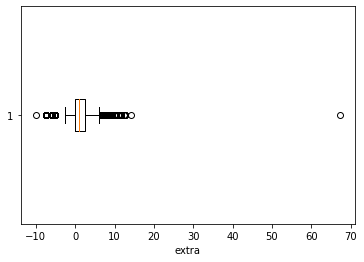

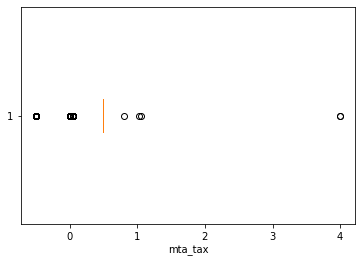

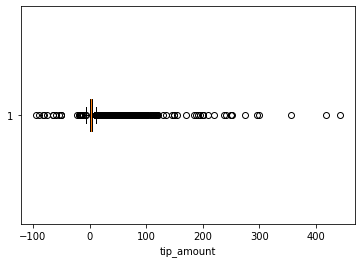

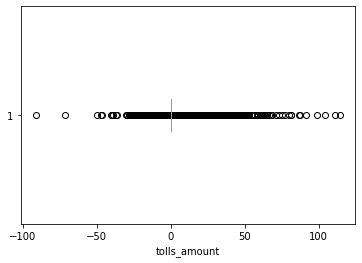

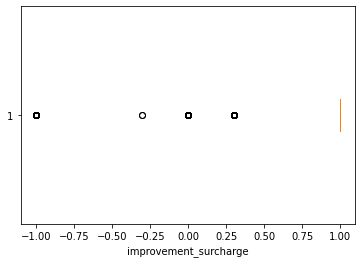

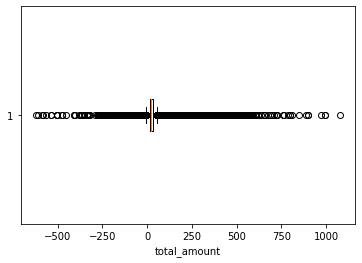

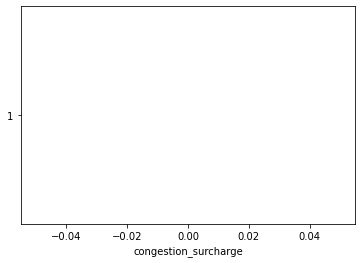

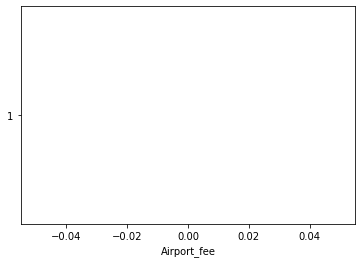

In [22]:
for col in numeric_columns:
    plt.boxplot(df[col], vert=False)
    plt.xlabel(col)
    plt.show()

In [25]:
df[(df.fare_amount>1_000)]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1004258,2,2023-07-13 08:57:00,2023-07-13 13:34:52,4.00,244.33,4.00,N,132,265,2,"1,040.40",0.00,0.00,0.00,36.30,1.00,"1,079.45",0.00,1.75


In [27]:
df[(df.fare_amount<0)].head(20)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
44,2,2023-07-01 00:27:16,2023-07-01 00:37:09,1.00,1.89,1.00,N,163,186,4,-12.10,-1.00,-0.50,0.00,0.00,-1.00,-17.10,-2.50,0.00
46,2,2023-07-01 00:38:59,2023-07-01 00:51:35,1.00,2.84,1.00,N,186,4,2,-15.60,-1.00,-0.50,0.00,0.00,-1.00,-20.60,-2.50,0.00
167,2,2023-07-01 00:01:53,2023-07-01 00:08:03,1.00,1.03,1.00,N,48,246,4,-7.90,-1.00,-0.50,0.00,0.00,-1.00,-12.90,-2.50,0.00
365,2,2023-07-01 00:23:54,2023-07-01 00:32:50,1.00,1.61,1.00,N,100,48,4,-10.70,-1.00,-0.50,0.00,0.00,-1.00,-15.70,-2.50,0.00
397,2,2023-07-01 00:14:51,2023-07-01 00:28:01,1.00,1.85,1.00,N,114,186,4,-13.50,-1.00,-0.50,0.00,0.00,-1.00,-18.50,-2.50,0.00
409,2,2023-07-01 00:46:40,2023-07-01 00:49:31,3.00,0.59,1.00,N,238,151,2,-5.10,-1.00,-0.50,2.02,0.00,-1.00,-8.08,-2.50,0.00
660,2,2023-07-01 00:16:56,2023-07-01 00:17:49,3.00,0.05,1.00,N,79,79,4,-3.00,-1.00,-0.50,0.00,0.00,-1.00,-8.00,-2.50,0.00
699,2,2023-07-01 00:17:40,2023-07-01 00:36:14,1.00,3.81,1.00,N,230,7,4,-21.20,-1.00,-0.50,0.00,0.00,-1.00,-26.20,-2.50,0.00
752,2,2023-07-01 00:50:26,2023-07-01 00:50:51,1.00,0.05,1.00,N,42,42,3,-3.00,-1.00,-0.50,0.00,0.00,-1.00,-5.50,0.00,0.00
768,2,2023-07-01 00:48:11,2023-07-01 00:51:07,1.00,0.09,1.00,N,164,164,2,-4.40,-1.00,-0.50,0.00,0.00,-1.00,-9.40,-2.50,0.00


In [ ]:
df.shape

In [ ]:
df.describe(include='all', datetime_is_numeric=True).T

In [ ]:
df.dtypes

In [ ]:
df.describe().T

In [ ]:
df.describe(include=["object"]).T

In [ ]:
df.describe(include=["datetime64"], datetime_is_numeric=True, percentiles=[]).T

## Missing Values

In [ ]:
n_rows = df.shape[0]
for col in df.columns:
    n_null_values = pd.isnull(df[col]).sum()
    n_unique = df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    print(f"{col}: rows={n_rows:,}   nulls={n_null_values:,}   uniques={n_unique}:")
    

In [ ]:
def nulls_uniques_count(df: pd.DataFrame, include_cols: List[str] = [], exclude_cols: List[str] = []) -> pd.DataFrame:
    cols = df.columns if len(include_cols)==0 else list(set(df.columns).intersection(set(include_cols)))
    if len(exclude_cols)>0:
        cols = set(cols)-set(exclude_cols)
        
    nulls_uniques_count_dat = [{
        'col': col,
        'null_values': pd.isnull(df[col]).sum(),
        'unique': df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    } 
    for col in cols ]
    nulls_uniques_count_df = pd.DataFrame(nulls_uniques_count_dat)
    nulls_uniques_count_df.set_index('col', inplace=True)
    nulls_uniques_count_df['null_values_perc'] = nulls_uniques_count_df['null_values']/df.shape[0]
    nulls_uniques_count_df['unique_perc'] = nulls_uniques_count_df['unique']/df.shape[0]
    return nulls_uniques_count_df

In [ ]:
nulls_uniques_count(df)

In [ ]:
nulls_uniques_count_dat = [{
        'col': col,
        'null_values': pd.isnull(df[col]).sum(),
        'unique': df[pd.notnull(df[col])][col].drop_duplicates().shape[0]
    } 
    for col in df.columns
]
nulls_uniques_count_df = pd.DataFrame(nulls_uniques_count_dat)
nulls_uniques_count_df.set_index('col', inplace=True)
nulls_uniques_count_df['null_values_perc'] = nulls_uniques_count_df['null_values']/df.shape[0]
nulls_uniques_count_df['unique_perc'] = nulls_uniques_count_df['unique']/df.shape[0]
display(nulls_uniques_count_df)
# display(nulls_uniques_count_df)

In [ ]:
df.describe().T.join(nulls_uniques_count_df)

In [ ]:
pd.DataFrame(df.dtypes, columns=['field_name']).join(df.describe().T, how='inner')

In [ ]:
df.groupby('passenger_count').agg({'passenger_count': 'count'})

In [ ]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(15,10))
pass_count_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].trip_distance, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Trip Distance [miles]", fontsize=16)
plt.xlabel("Frequency", fontsize=16)
plt.title("Dsitribution of Trip Distance", fontsize=28)
fig.show()
fig.savefig('plot_1_15x10.png')

In [ ]:
plt.yticks()

In [ ]:
df[df.trip_distance<10]

In [ ]:
len(mcolors.TABLEAU_COLORS)

list(mcolors.TABLEAU_COLORS)

In [ ]:
df.columns

In [28]:
# List of numeric columns
num_cols = [ col for col, datyp in df.dtypes.items() if datyp in ['int64', 'float64'] ]

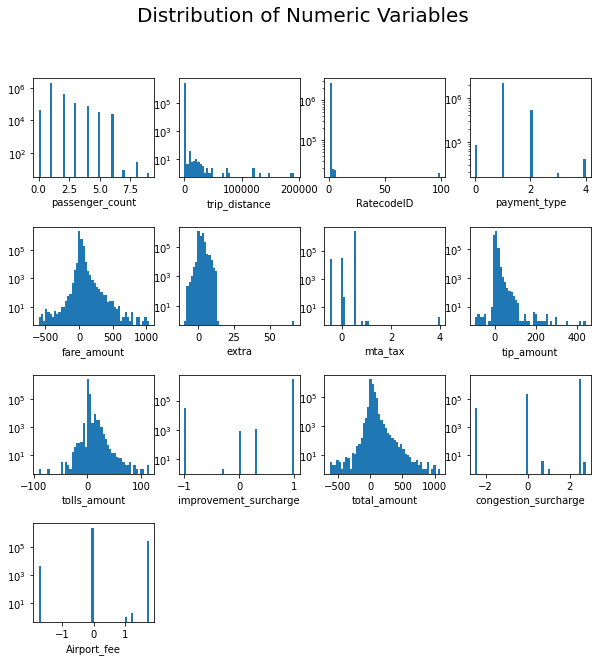

In [29]:
import math
a = math.ceil(math.sqrt(len(num_cols)))
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.5)
j = 0
for col in num_cols:
    j += 1
    plt.subplot(a, a, j)
    plt.hist(df[col], bins=50, log=True)
    plt.xlabel(col)
plt.suptitle("Distribution of Numeric Variables", fontsize=20)
plt.show()

In [31]:
scatt_cols = [ col for col in num_cols if 'ID' not in col] 

In [32]:
df2 = df.sample(1000)
scatt_cols = [ col for col in num_cols if 'ID' not in col] 

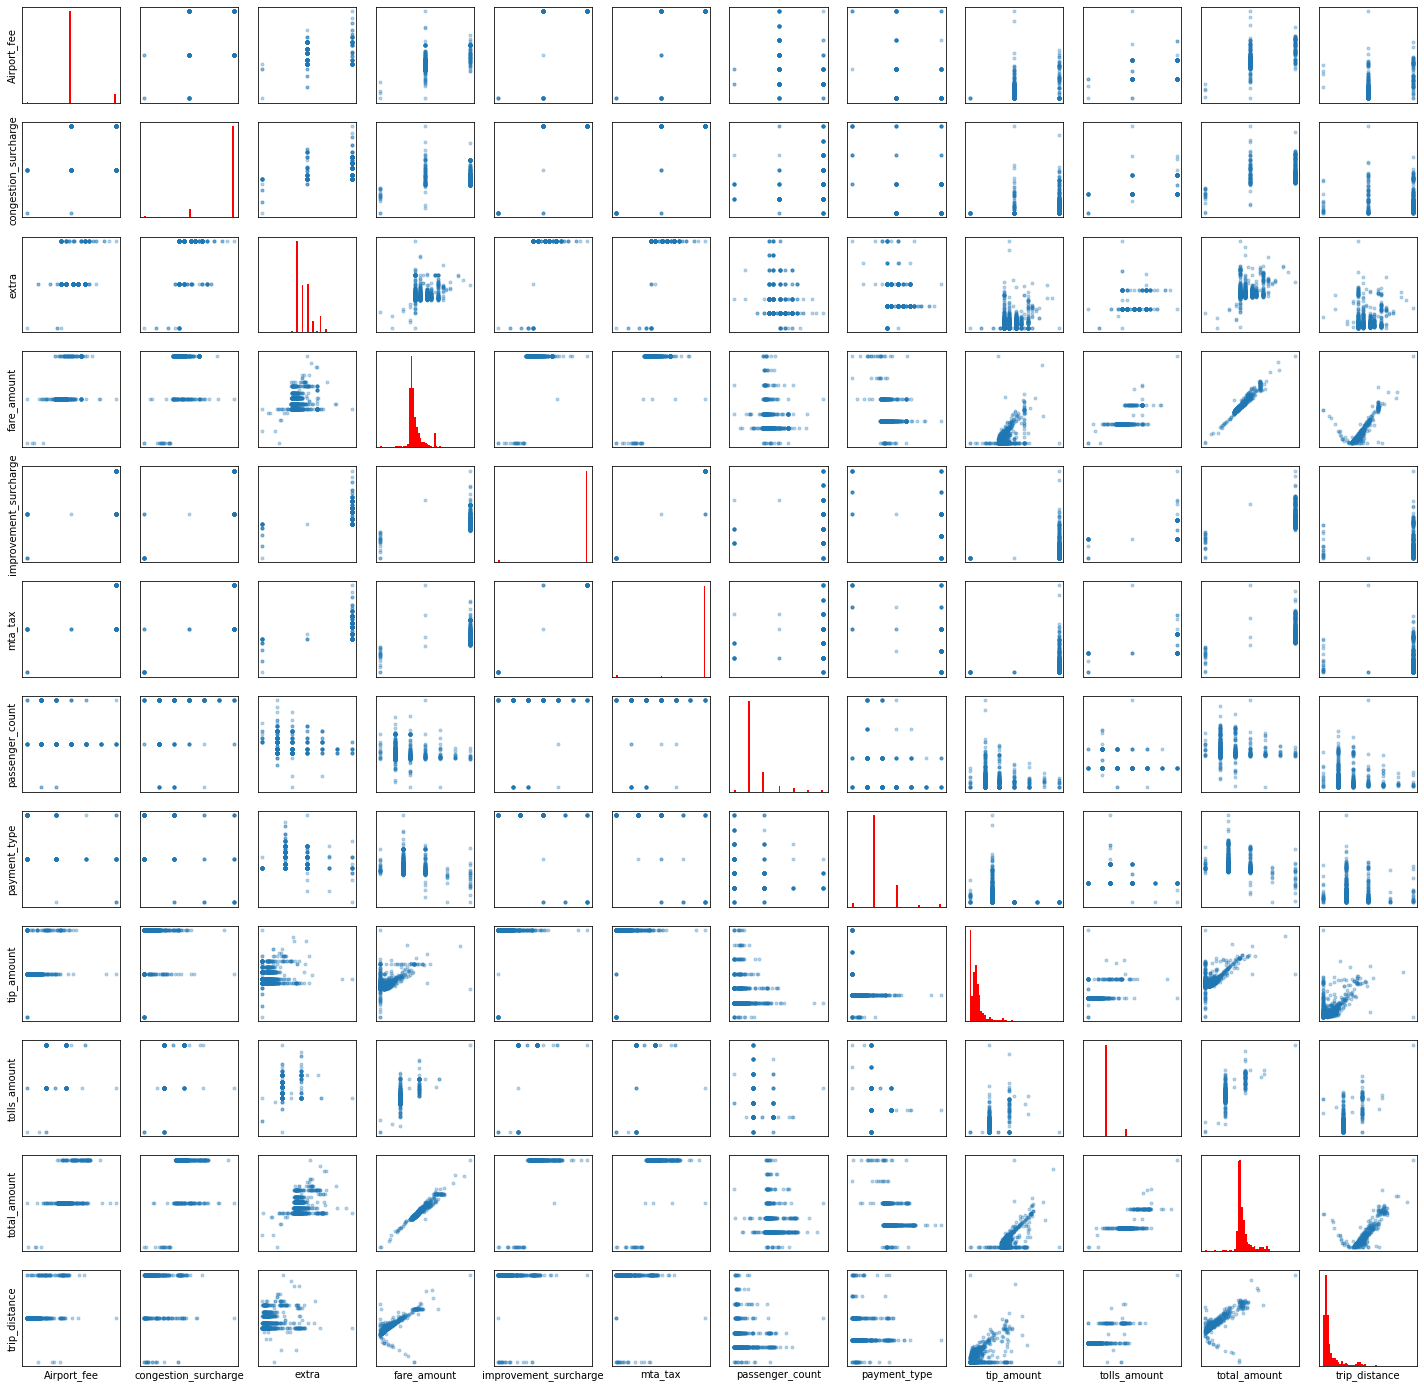

In [33]:
j = 0
n_scatt = len(scatt_cols)
fig = plt.figure(figsize=(25,25))
for row in sorted(scatt_cols):
    for col in sorted(scatt_cols):
        j += 1
        plt.subplot(n_scatt, n_scatt, j)
        if row == col:
            plt.hist(df2[col], bins=50, color='r')
        else:
            plt.plot(df2[row], df2[col], '.', alpha=0.3)
        plt.xticks([])
        plt.yticks([])
        if j % n_scatt == 1:
            plt.ylabel(row)
        if j / n_scatt > n_scatt - 1:
             plt.xlabel(col)
plt.show()

In [ ]:
df.trip_distance.corr(df.total_amount)

In [ ]:
plt.boxplot(df.trip_distance, vert=False)

# PowerPoint

The default dimensions of a Powepoint slide are 13.33 inches by 7.5 inches.

E.g, a single figure on the slide can have the dimensions of 11x6.5

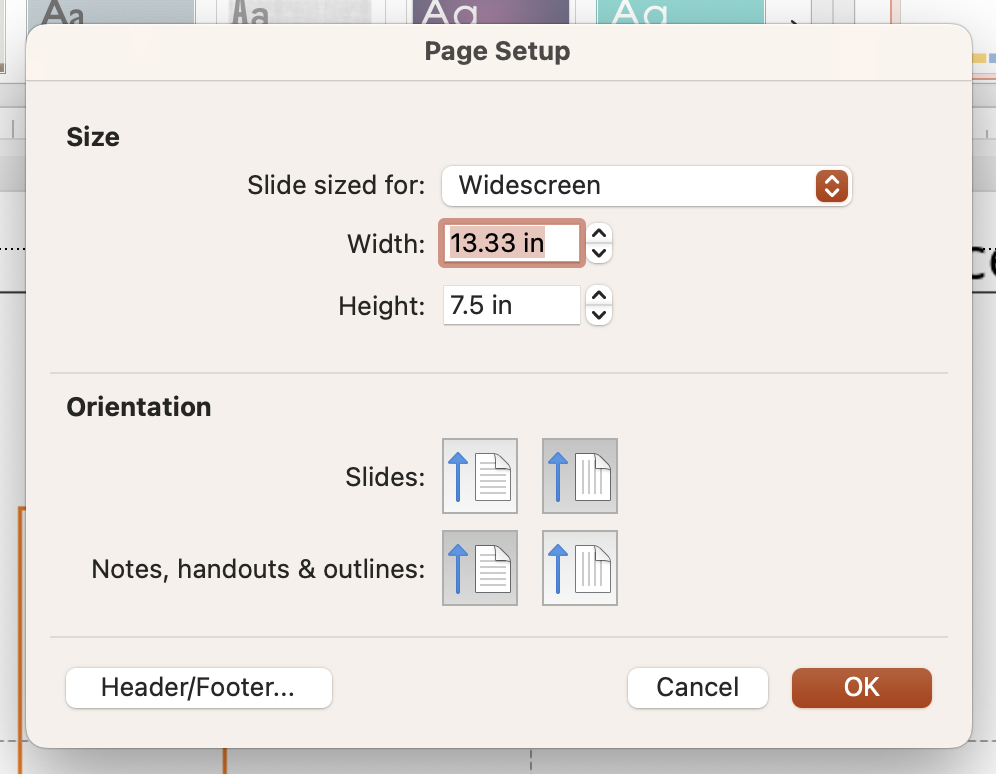

## Distribution of Trip Distance

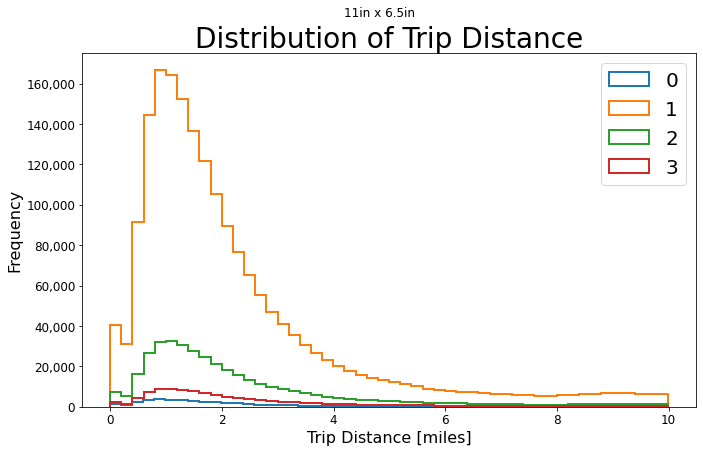

In [36]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(11,6.5))
pass_count_values = [0, 1, 2, 3, ] ## 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].trip_distance, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Trip Distance [miles]", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Trip Distance", fontsize=28)
plt.suptitle("11in x 6.5in", fontsize=12)
fig.show()
fig.savefig('plot_1_110x65.png')
# plt.close()

## Distribution of Fair Amount

In [ ]:
import matplotlib
import matplotlib.colors as mcolors
fig = plt.figure(figsize=(11,6.5))
pass_count_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# mcolors.TABLEAU_COLORS
for n, c in zip(pass_count_values, list(mcolors.TABLEAU_COLORS)[:len(pass_count_values)]):
    plt.hist(df[(df.passenger_count==n)&(df.trip_distance<10)].fare_amount, bins=50, label=f'{n}', histtype='step', color=c, linewidth=2,)
plt.legend(fontsize="20")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.axes[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Fare [$]", fontsize=16)
plt.xlabel("Frequency", fontsize=16)
plt.title("Distribution of Fair Amount", fontsize=28)
plt.suptitle("11in x 6.5in", fontsize=12)
fig.show()
fig.savefig('plot_2_110x65.png')
# plt.close()

## Include Data Quality Table

Create a table

In [ ]:
quality_numeric = df.describe(datetime_is_numeric=True).T
display(quality_numeric)

Export to Excel:

In [ ]:
quality_numeric.to_excel('table_quality_numeric.xlsx', index_label='field')

Downlaod Excel file, and drag onto the PowerPoint slide.